This notebook demonstrates how extent time series data for each ecosystem was aggregated or generated based on available scientific findings.

See the README.md for more information on purpose, sourcing, and summaries of each methodoolgy.

In [1]:
import pandas as pd
import rioxarray
import xarray as xr
import ee
import geemap
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline

#### Utility Functions

In [63]:
def SplineFit(ecosystem_data, y_col, start_date=1970, end_date=2020, s=3, k=3):
    """ Generate a spline and interpolate values """
    # Fit a univariate spline to the Rescaled values with respect to Year
    spline = UnivariateSpline(ecosystem_data["Year"], ecosystem_data[y_col], s=s, k=k)

    # Generate interpolated values for each year
    years_interp = np.arange(start_date, end_date)
    value_interp = spline(years_interp) * 100

    interpolated_df = pd.DataFrame({"Year": years_interp, "Value": value_interp})

    return interpolated_df

In [107]:
def VisualizeSpline(original_data, y_col, interpolated_data, title):

    plt.scatter(original_data["Year"], original_data[y_col] * 100, color = 'green')
    plt.plot(interpolated_data['Year'],interpolated_data['Value'], linestyle = "--", color = 'green')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Percent')
    plt.grid(True)

    plt.show()
    return

#### Mangroves

In [ ]:
# Create mangrove dataframe based on 
# 1) 1970 extent value from Spalding et. al (1997) and FAO decadal mangrove extent datasets, 
# using 2) a 1980 extent value from a dataset covering 1980-2005 (2007), 
# and 3) data onwards from a dataset covering 1990-2020 (2020)

mangrove_area = [20000, 18794, 15759, 15292, 14928, 14717]
mangrove_year = [1970, 1980, 1990, 2000, 2010, 2020]

mangroves = pd.DataFrame({"Year": mangrove_year, "area_ha": mangrove_area})
mangroves['Rescaled'] = mangroves['area_ha'].apply(lambda x: round(x / mangroves['area_ha'].iloc[0], 5))

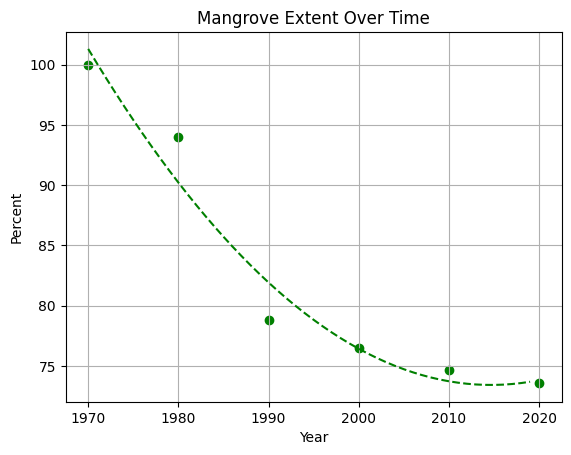

In [ ]:
# Call spline function
mangroves_interpolated = SplineFit(mangroves, "Rescaled", start_date=1970, end_date=2020, s=3, k=2)

# Plot
VisualizeSpline(mangroves, "Rescaled", mangroves_interpolated, "Mangrove Extent Over Time")

# Export
mangroves_interpolated[['Year','Value']].to_csv("mangroves_timeseries.csv")

#### Tidal flats

Use Google Earth Engine to obtain pixel counts from Murray et. al. dataset

In [ ]:
# Use Google Earth Engine (GEE) to get tidal flat pixels over time

# Initialize GEE Project
ee.Initialize(project='my-project')

# Get dataset
tidal_flats = ee.ImageCollection("UQ/murray/Intertidal/v1_1/global_intertidal")
indexes = ee.List(tidal_flats.aggregate_array("system:index"))

# Define global ROI
roi = ee.Geometry.Polygon(
    [[[-180, -90], [-180, 90], [180, 90], [180, -90], [-180, -90]]],
    None,
    False
)

# Get mask of where pixels were measured
image_1989 = ee.Image(tidal_flats.toList(2).get(1))
valid_mask = image_1989.mask()

# Function to count pixels for each image
def count_positive(index):
    image = tidal_flats.filter(ee.Filter.eq("system:index", index)).first()

    # Attempt to match to early time point to filter out newly measured pixels
    masked_image = image.updateMask(valid_mask)

    # Count positive pixels (presence of tidal flat)
    positive = image.eq(1)
    count = positive.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=30,
        maxPixels=1e13
    ).get("classification")

    return ee.Feature(None, {
        "period": index,
        "pixel_count": count
    })

# Apply to all indexes
result_fc = ee.FeatureCollection(indexes.map(count_positive))

task = ee.batch.Export.table.toDrive(
    collection=result_fc,
    description='tidal_flat_by_period',
    fileFormat='CSV'
)
task.start()

In [ ]:
# Use Google Earth Engine (GEE) to get valid tidal flat pixels measured over time

# Get dataset
qa_ic = ee.ImageCollection("UQ/murray/Intertidal/v1_1/qa_pixel_count").select("pixel_count")
periods = ee.List(qa_ic.aggregate_array("system:index"))

# Define global ROI
global_roi = ee.Geometry.Polygon(
    [[[-180, -90], [-180, 90], [180, 90], [180, -90], [-180, -90]]],
    None,
    False
)

# Function to count pixels with at least one observation
def count_valid_pixels(index):
    image = qa_ic.filter(ee.Filter.eq("system:index", index)).first()
    
    # Create a binary image: 1 where pixel_count > 0
    valid_mask = image.gt(0)
    
    # Count the number of non-zero pixels by summing the 1s
    count = valid_mask.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=global_roi,
        scale=30,
        maxPixels=1e13
    ).get("pixel_count")

    return ee.Feature(None, {
        "period": index,
        "nonzero_pixel_count": count
    })

# Apply function to each period
pixel_summary_fc = ee.FeatureCollection(periods.map(count_valid_pixels))

# Export to Google Drive as CSV
task = ee.batch.Export.table.toDrive(
    collection=pixel_summary_fc,
    description="intertidal_pixel_count_summary",
    fileFormat="CSV"
)
task.start()

Download processed data from GEE first, then move on

In [ ]:
tidal_flats_eco = pd.read_csv('tidal_flat_by_period.csv').drop(columns = ["system:index",".geo"])
tidal_flats_qa = pd.read_csv('intertidal_pixel_count_summary.csv').drop(columns = ["system:index",".geo"])
tidal_flats_ts = pd.merge(tidal_flats_eco, tidal_flats_qa, on='period')
tidal_flats_ts['percent'] = tidal_flats_ts['positive_pixel_count'] / tidal_flats_ts['nonzero_pixel_count']
tidal_flats_ts['Year'] = [1985, 1988, 1991, 1994, 1997, 2000, 2003, 2006, 2009, 2012, 2015]
tidal_flats_ts['Rescaled'] = tidal_flats_ts['percent'] / tidal_flats_ts['percent'].iloc[0]
#tidal_flats_ts.to_csv('tidal_flat_percent.csv')
tidal_flats_ts

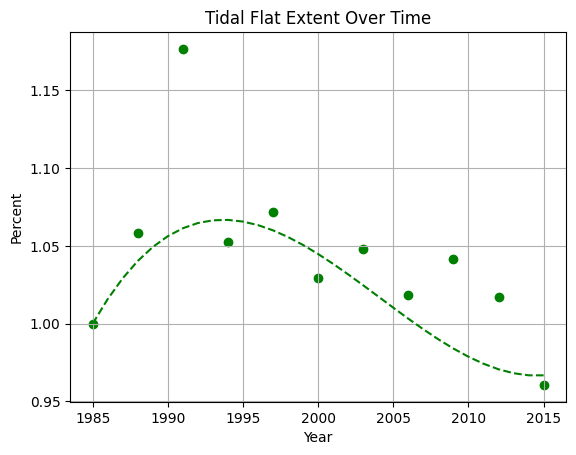

In [ ]:
# Import data
tidal_flats_eco = pd.read_csv('tidal_flat_by_period.csv').drop(columns = ["system:index",".geo"])
tidal_flats_qa = pd.read_csv('intertidal_pixel_count_summary.csv').drop(columns = ["system:index",".geo"])

# Normalize pixel count by pixels measure
tidal_flats = pd.merge(tidal_flats_eco, tidal_flats_qa, on='period')
tidal_flats['percent'] = tidal_flats['positive_pixel_count'] / tidal_flats['nonzero_pixel_count']
tidal_flats['Year'] = [1985, 1988, 1991, 1994, 1997, 2000, 2003, 2006, 2009, 2012, 2015]
tidal_flats['Rescaled'] = tidal_flats['percent'] / tidal_flats['percent'].iloc[0] 

# Call spline function
tidal_flats_interpolated = SplineFit(tidal_flats, "percent", 1985, 2016, s=3, k=3)
tidal_flats_interpolated["Rescaled"] = tidal_flats_interpolated["Value"] / tidal_flats_interpolated[tidal_flats_interpolated['Year'] == 1985]["Value"].values

# Plot
plt.plot(tidal_flats_interpolated['Year'],tidal_flats_interpolated['Rescaled'], linestyle = '--', color = 'green')
plt.scatter(tidal_flats["Year"], tidal_flats["Rescaled"], color = 'green')
plt.title('Tidal Flat Extent Over Time')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.grid(True)

# Export
tidal_flats_interpolated[['Year','Value']].to_csv("tidal_flats_timeseries.csv")

#### Oyster reefs

In [ ]:
# Create dataset by visual inspection of Mcafee 2020 results

oyster_area = [130, 125, 112, 78, 51, 40, 37, 38, 38.5, 39, 42, 43, 48, 54, 58, 68, 75]
oyster_year = [1800, 1825, 1850, 1875, 1900, 1925, 1930, 1940, 1950, 1960, 1970, 1975, 1980,1990, 2000, 2010, 2015]
native_oyster_area = [130, 125, 112, 78, 51, 39, 38, 36, 35, 32, 29, 28, 27, 24, 23, 22.5, 22]
oyster_reef = pd.DataFrame({"Year": oyster_year, "extent_1000km": oyster_area})
native_oyster_reef = pd.DataFrame({"Year": oyster_year, "extent_1000km": native_oyster_area})
native_oyster_reef = pd.DataFrame({"Year": oyster_year, "extent_1000km": native_oyster_area})

# Get rescaled values with first year as baseline
native_oyster_reef['Rescaled'] = 100*native_oyster_reef['extent_1000km'].apply(lambda x: round(x / oyster_reef['extent_1000km'].iloc[0], 5))
oyster_reef['Rescaled'] = 100*oyster_reef['extent_1000km'].apply(lambda x: round(x / oyster_reef['extent_1000km'].iloc[0], 5))

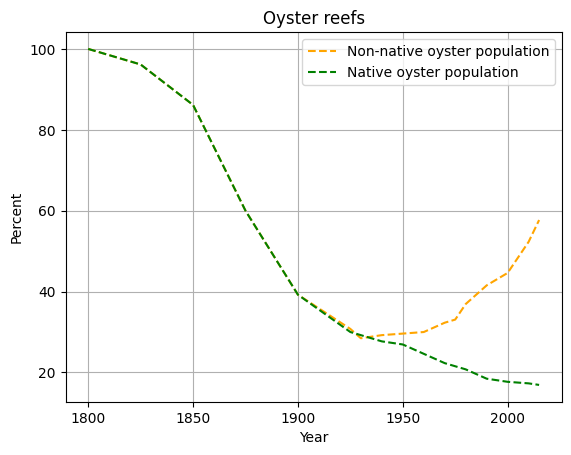

In [ ]:
# Plotting for oyster reefs is different due to native and non-native split

plt.plot(oyster_reef['Year'],oyster_reef['Rescaled'], linestyle = "--", color= 'orange')
plt.plot(native_oyster_reef['Year'],native_oyster_reef['Rescaled'], linestyle = "--", color= 'green')
plt.title("Oyster reefs")
plt.xlabel('Year')
plt.ylabel('Percent')
plt.legend(["Non-native oyster population","Native oyster population"])
plt.grid(True)

# Export
oyster_reef.to_csv("oyster_reef_timeseries.csv")

#### Kelp

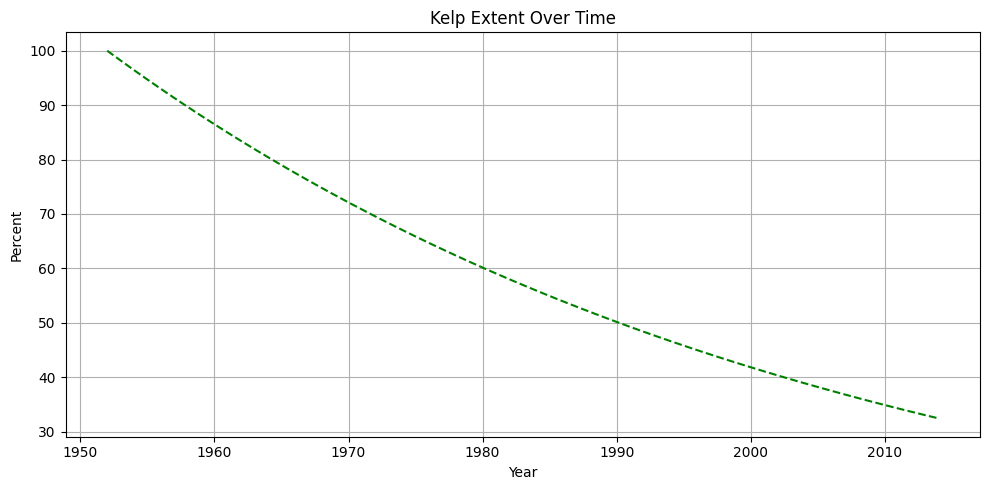

In [ ]:
# Given a 1.8% yearly decline, define exponential decay parameters
start_year = 2015
annual_rate = -1.8 / 100  # Convert percent to decimal
initial_value = 100
years = np.arange(1952, start_year)
time_elapsed = years - 1952

# Exponential decay formula: value = initial * (1 + rate) ** time
values_exp = initial_value * (1 + annual_rate) ** time_elapsed

# Create DataFrame
kelp = pd.DataFrame({'Year': years, 'Value': values_exp})

# Plot the exponential decline, no point data available
plt.figure(figsize=(10, 5))
plt.plot(kelp['Year'], kelp['Value'], linestyle='--', color='green')
plt.title('Kelp Extent Over Time')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.grid(True)
plt.tight_layout()

plt.show()

# Export
kelp[['Year','Value']].to_csv("kelp_timeseries.csv")

#### Salt marshes

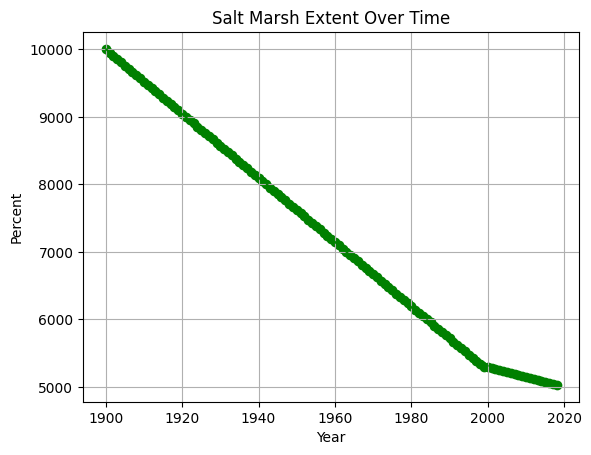

In [ ]:
# Define exponential decay parameters given a 50% historical decline in salt marsh coverage, documented by Crooks et. al. (2011), 
# and a 0.28% annual rate of decline in the years 2000-2019
diff = 50 # Total difference in %
start_year = 2000
annual_rate = -.28 / 100  # Convert percent to decimal
initial_value = .5 / ((1-.0028)**20)*100
years = np.arange(2000, 2019)
time_elapsed = years - 2000

# Exponential decay formula: value = initial * (1 + rate) ** time
values_exp = initial_value * (1 + annual_rate) ** time_elapsed

# pre 2000
years_pre = np.arange(1900, start_year)
values_pre = np.linspace(100, initial_value, len(years_pre))  # Linear interpolation from 100 to initial_value

# Combine both periods
years_full = np.concatenate([years_pre, years])
values_full = np.concatenate([values_pre, values_exp])

# Create DataFrame
salt_marshes = pd.DataFrame({'Year': years_full, 'percent': values_full})

# Call spline function
salt_marshes_interpolated = SplineFit(salt_marshes, "percent", 1900, 2019, s=3, k=3)

# Plot
VisualizeSpline(salt_marshes, "percent", salt_marshes_interpolated, "Salt Marsh Extent Over Time")

# Export
salt_marshes_interpolated[['Year','Value']].to_csv("salt_marshes_timeseries.csv")

#### Seagrass

Seagrass extent data was generated via the code in this repo: https://github.com/jdunic/2021_Global-seagrass-trends

After it was generated, it was processed using seagrass_processing.r to generate seagrass_timeseries.csv.

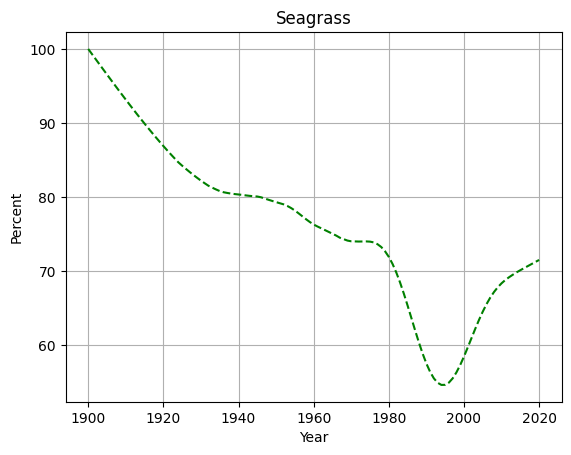

In [ ]:
# Import Data
seagrass = pd.read_csv('seagrass_timeseries.csv')

# Plot
plt.plot(seagrass['year'],seagrass['mean_pct'], linestyle = "--", color= 'green')
plt.title("Seagrass Extent Over Time")
plt.xlabel('Year')
plt.ylabel('Percent')
plt.grid(True)

#### Coral

In [ ]:
# Read in text CSV with desk research estimations
coral_estimations = pd.read_csv('global_coral_cover_timeseries.csv')

# Fill in numeric data manually based on text
coral_estimations.loc[0,"Percent"] = np.array([58,70]).mean()
coral_estimations.loc[0,"Year/Period"] = 1955

coral_estimations.loc[1,"Percent"] = 50
coral_estimations.loc[1,"Year/Period"] = 1975

coral_estimations.loc[2,"Percent"] = np.array([40,45]).mean()
coral_estimations.loc[2,"Year/Period"] = 1985

coral_estimations.loc[3,"Percent"] = 30
coral_estimations.loc[3,"Year/Period"] = 1998

coral_estimations.loc[4,"Percent"] = 30
coral_estimations.loc[4,"Year/Period"] = 2000

coral_estimations.loc[5,"Percent"] = 30
coral_estimations.loc[5,"Year/Period"] = 2007

coral_estimations.loc[6,"Percent"] = 28.8
coral_estimations.loc[6,"Year/Period"] = 2012

coral_estimations.loc[7,"Percent"] = 26.8
coral_estimations.loc[7,"Year/Period"] = 2017
coral_estimations = coral_estimations.drop(index = 8)

# Assume 1950 value is similar to 1900
coral_estimations.loc[8] = [1900, "","","",np.array([58,70]).mean()]
coral_estimations["Percent"]  = coral_estimations["Percent"] / 100
coral_estimations = coral_estimations.rename(columns={"Year/Period":"Year"}).sort_values(by = "Year",ascending=True)
coral_estimations['Rescaled'] = coral_estimations['Percent'] / coral_estimations['Percent'].iloc[0]

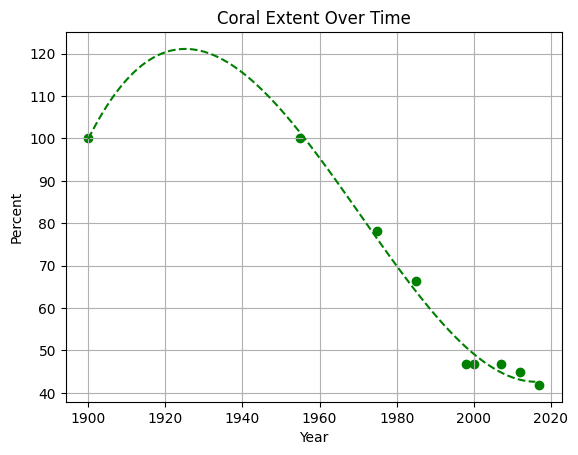

In [ ]:
# Call spline function
coral_estimations_interpolated = SplineFit(coral_estimations, "Rescaled", start_date=1900, end_date=2017, s=3, k=3)

# Plot
VisualizeSpline(coral_estimations, "Rescaled", coral_estimations_interpolated, "Coral Extent Over Time")

# Export
coral_estimations_interpolated[['Year','Value']].to_csv("mangroves_timeseries.csv")